In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Image dimensions
IMG_WIDTH = 128
IMG_HEIGHT = 128
CHANNELS = 3

RAW_PATH = 'Dataset/Train/Raw'
REFERENCE_PATH = 'Dataset/Train/Reference'

def load_images_from_folder(folder, img_width=IMG_WIDTH, img_height=IMG_HEIGHT):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img_array)
    return np.array(images)

raw_images = load_images_from_folder(RAW_PATH)
reference_images = load_images_from_folder(REFERENCE_PATH)


In [7]:
LATENT_DIM = 100  # Size of the latent space

# Encoder Network
def build_encoder():
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    
    z_mean = layers.Dense(LATENT_DIM)(x)
    z_log_var = layers.Dense(LATENT_DIM)(x)
    
    return Model(inputs, [z_mean, z_log_var], name="encoder")

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Decoder Network
def build_decoder():
    latent_inputs = layers.Input(shape=(LATENT_DIM,))
    x = layers.Dense(32 * 32 * 128, activation='relu')(latent_inputs)
    x = layers.Reshape((32, 32, 128))(x)
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    outputs = layers.Conv2DTranspose(CHANNELS, (3, 3), activation='sigmoid', padding='same')(x)
    
    return Model(latent_inputs, outputs, name="decoder")

# VAE model
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    
    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = sampling([z_mean, z_log_var])
        reconstructed = self.decoder(z)
        return reconstructed, z_mean, z_log_var

# Instantiate encoder and decoder
encoder = build_encoder()
decoder = build_decoder()
vae = VAE(encoder, decoder)

In [8]:
# Loss function
def vae_loss(y_true, y_pred, z_mean, z_log_var):
    # Reconstruction loss (MSE)
    mse_loss = MeanSquaredError()(y_true, y_pred) * IMG_HEIGHT * IMG_WIDTH * CHANNELS
    
    # KL Divergence Loss
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    
    return mse_loss + kl_loss

class VAELoss(Model):
    def __init__(self, vae, **kwargs):
        super(VAELoss, self).__init__(**kwargs)
        self.vae = vae

    def train_step(self, data):
        noisy_images, clean_images = data
        with tf.GradientTape() as tape:
            reconstructed_images, z_mean, z_log_var = self.vae(noisy_images)
            loss = vae_loss(clean_images, reconstructed_images, z_mean, z_log_var)
        
        gradients = tape.gradient(loss, self.vae.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.vae.trainable_weights))
        return {"loss": loss}

# Compilation of model
vae_loss_model = VAELoss(vae)
vae_loss_model.compile(optimizer='adam')
vae_loss_model.summary()

Model: "vae_loss_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vae_1 (VAE)                          │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,160,715 (179.90 MB)

 Trainable params: 47,160,715 (179.90 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
encoder.summary()
decoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 32)      │             896 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 64, 64, 32)        │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 64)        │          18,496 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 32, 32, 64)        │               0 │ conv2d_4[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 32, 32, 128)       │          73,856 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 131072)            │               0 │ conv2d_5[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 256)               │      33,554,688 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 100)               │          25,700 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 100)               │          25,700 │ dense_4[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 33,699,336 (128.55 MB)

 Trainable params: 33,699,336 (128.55 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 131072)              │      13,238,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 128, 128, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,461,379 (51.35 MB)

 Trainable params: 13,461,379 (51.35 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model
batch_size = 28
epochs = 500

dataset = tf.data.Dataset.from_tensor_slices((raw_images, reference_images)).batch(batch_size)

vae_loss_model.fit(dataset, epochs=epochs)

Epoch 1/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - loss: 2954.4138
Epoch 2/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - loss: 2717.3684
Epoch 3/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 2503.5454
Epoch 4/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - loss: 2363.9299
Epoch 5/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - loss: 2316.5068
Epoch 6/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 2214.3889
Epoch 7/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - loss: 2124.5947
Epoch 8/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - loss: 2014.1954
Epoch 9/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - loss: 1975.4203
Epoch 10/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 1930.9152
Epoch 11/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 1892.0966
Epoch 12/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - loss: 1845.8466
Epoch 13/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - loss: 1841.7646
Epoch 14/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - loss: 1829.8453
Epoch 15/500
25/25 ━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 596ms/step


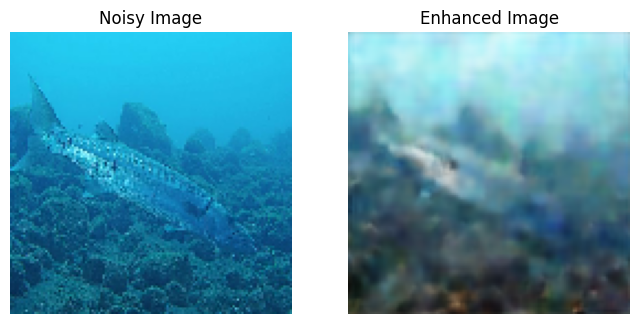

In [11]:
# Evaluate on test images (assuming test data is pre-loaded)
enhanced_images, _, _ = vae.predict(raw_images)

# Display some example images
def display_image_comparison(noisy, enhanced):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title('Noisy Image')
    plt.imshow(noisy)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Enhanced Image')
    plt.imshow(enhanced)
    plt.axis('off')

    plt.show()

# Display the first test image and its enhanced version
display_image_comparison(raw_images[0], enhanced_images[0])


In [12]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import psnr as tf_psnr, ssim as tf_ssim
from tensorflow.image import resize

# Set image dimensions
IMG_WIDTH = 128
IMG_HEIGHT = 128
CHANNELS = 3

RAW_TEST_PATH = 'Dataset/Test/Raw'
REFERENCE_TEST_PATH = 'Dataset/Test/Reference'

def load_images_from_folder(folder, img_width=IMG_WIDTH, img_height=IMG_HEIGHT):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img_array)
    return np.array(images)

raw_test_images = load_images_from_folder(RAW_TEST_PATH)
reference_test_images = load_images_from_folder(REFERENCE_TEST_PATH)

predicted_images = vae.predict(raw_test_images)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 571ms/step


In [13]:
predicted_images[0].shape

(190, 128, 128, 3)

In [14]:
reference_test_images[0].shape

(128, 128, 3)

In [15]:
# Define MSE, PSNR, and SSIM functions
def mse(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

def psnr(y_true, y_pred):
    max_pixel = 1.0
    return 20 * np.log10(max_pixel / np.sqrt(mse(y_true, y_pred)))

def ssim(y_true, y_pred):
    return tf.reduce_mean(tf_ssim(y_true, y_pred, max_val=1.0))

In [16]:
mse_values = []
psnr_values = []
ssim_values = []

for i in range(len(predicted_images[0])):
    mse_val = mse(reference_test_images[i], predicted_images[0][i])
    psnr_val = psnr(reference_test_images[i], predicted_images[0][i])
    ssim_val = ssim(reference_test_images[i], predicted_images[0][i])
    
    mse_values.append(mse_val)
    psnr_values.append(psnr_val)
    ssim_values.append(ssim_val)

# Calculate the mean of the evaluation metrics over the test set
mean_mse = np.mean(mse_values)
mean_psnr = np.mean(psnr_values)
mean_ssim = np.mean(ssim_values)

print(f"Mean MSE: {mean_mse}")
print(f"Mean PSNR: {mean_psnr}")
print(f"Mean SSIM: {mean_ssim}")

Mean MSE: 0.05975421518087387
Mean PSNR: 12.502228682540375
Mean SSIM: 0.160603865981102
